# Table of Content:
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Second Bullet Header](#second-bullet)

---

# Introduction


---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, classification_report
from xgboost import XGBClassifier, plot_importance


In [2]:
# Loading the dataset
data = pd.read_excel("/kaggle/input/company-house-info/Company_house_info.xlsx")

In [3]:
data.shape # Shows that size of the dataset

(6665, 96)

# Data Pre-processing
## Handle whitespace in column names
The names of the columns are formated to remove trailing spaces, spaces between word and making the the case uniform

In [4]:
data.columns= [i.lower() for i in data.columns] # Make all column names lowercase
data.columns= [i.strip() for i in data.columns] # Removes trailing spaces from column names
data.columns= [i.replace(' ', '_') for i in data.columns] # Replace spaces in column names with "_"


In [5]:
data.columns

Index(['bankrupt?', 'roa(c)_before_interest_and_depreciation_before_interest',
       'roa(a)_before_interest_and_%_after_tax',
       'roa(b)_before_interest_and_depreciation_after_tax',
       'operating_gross_margin', 'realized_sales_gross_margin',
       'operating_profit_rate', 'pre-tax_net_interest_rate',
       'after-tax_net_interest_rate',
       'non-industry_income_and_expenditure/revenue',
       'continuous_interest_rate_(after_tax)', 'operating_expense_rate',
       'research_and_development_expense_rate', 'cash_flow_rate',
       'interest-bearing_debt_interest_rate', 'tax_rate_(a)',
       'net_value_per_share_(b)', 'net_value_per_share_(a)',
       'net_value_per_share_(c)', 'persistent_eps_in_the_last_four_seasons',
       'cash_flow_per_share', 'revenue_per_share_(yuan_â¥)',
       'operating_profit_per_share_(yuan_â¥)',
       'per_share_net_profit_before_tax_(yuan_â¥)',
       'realized_sales_gross_profit_growth_rate',
       'operating_profit_growth_rate', 'after-

---
## Missing values

In [6]:
data.isnull().sum().sum()

0

In [7]:
# Check for missing values
missing_values = data.isnull().sum()

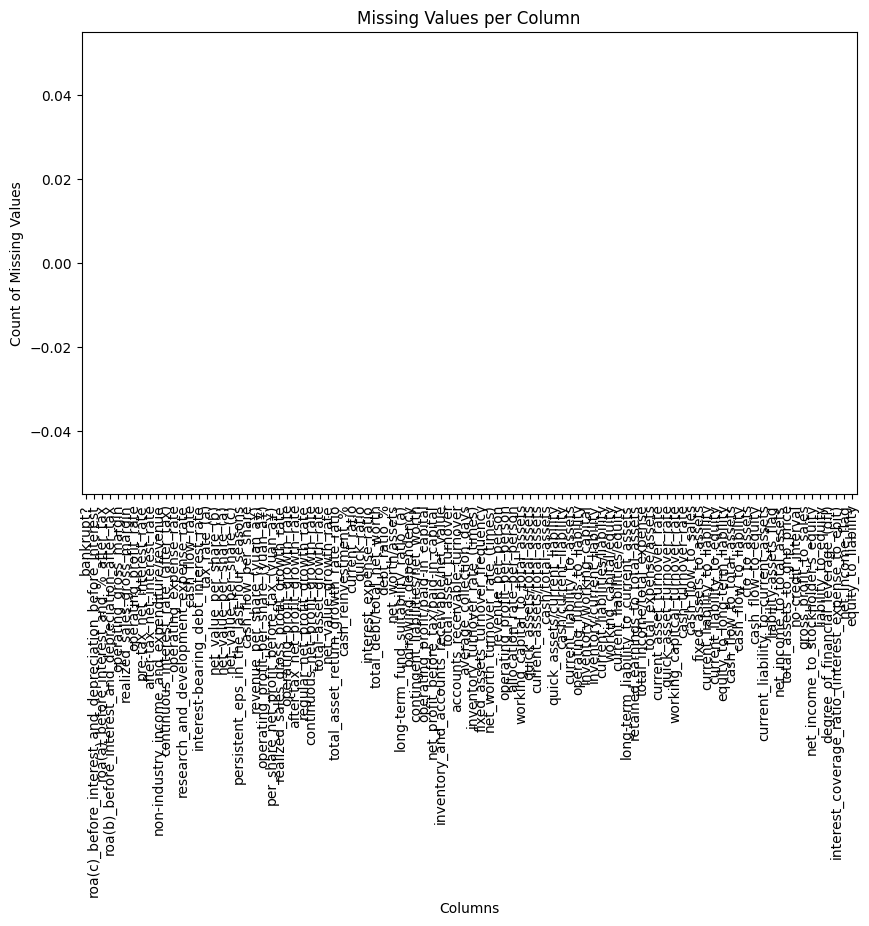

Series([], dtype: int64)

In [8]:
# Visualize missing values
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.show()

missing_values[missing_values > 0]

---
## Duplicate values

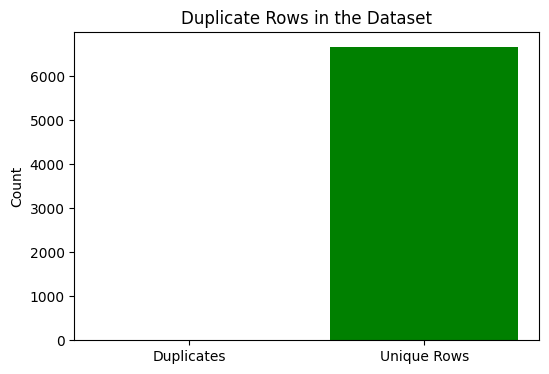

0

In [9]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

# Visualize the number of duplicates
plt.figure(figsize=(6, 4))
plt.bar(['Duplicates', 'Unique Rows'], 
        [len(duplicate_rows), 
         len(data) - len(duplicate_rows)], color=['red', 'green'])
plt.title('Duplicate Rows in the Dataset')
plt.ylabel('Count')
plt.show()

# Output duplicate rows count
len(duplicate_rows)

---
## Outlier Detection In Numeric Columns

### Boxplot for *"net_income_to_total_assets"* variable

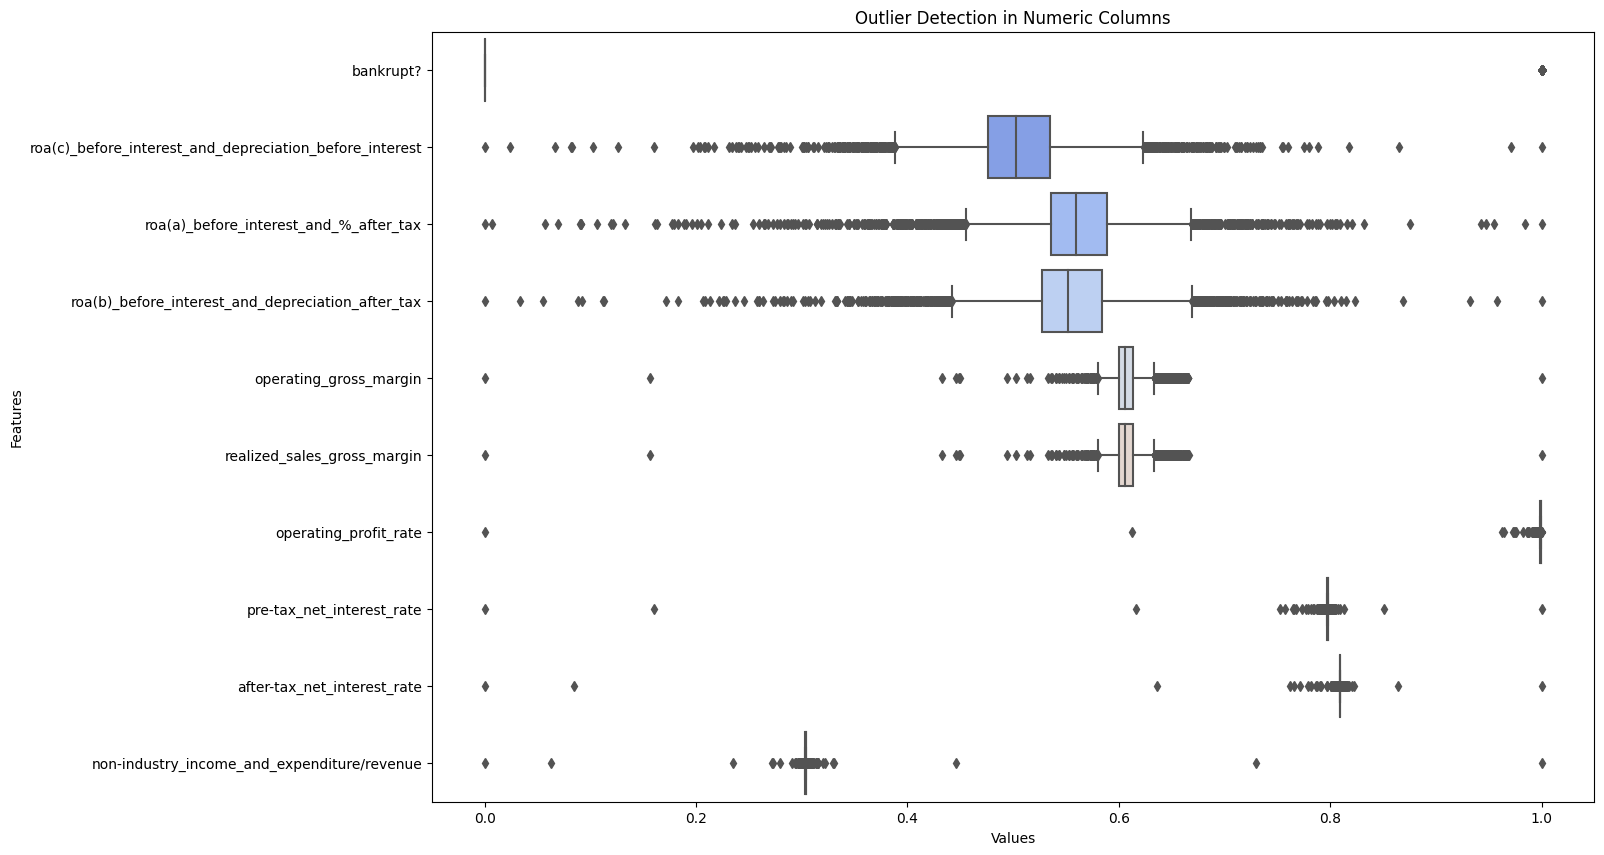

In [10]:
# Selecting numeric columns for outlier detection
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Visualizing outliers using box plots for a subset of numeric columns (to avoid clutter)
subset_columns = numeric_columns[:10]  # Analyzing first 10 numeric columns for demonstration

plt.figure(figsize=(15, 10))
sns.boxplot(data=data[subset_columns], orient='h', palette='coolwarm')
plt.title('Outlier Detection in Numeric Columns')
plt.xlabel('Values')
plt.ylabel('Features')
plt.show()

From the box plot above there are substantial amount values outsite the opper and lower bounds so they'll have to be identified to get more detail.

## Robust Rcaling

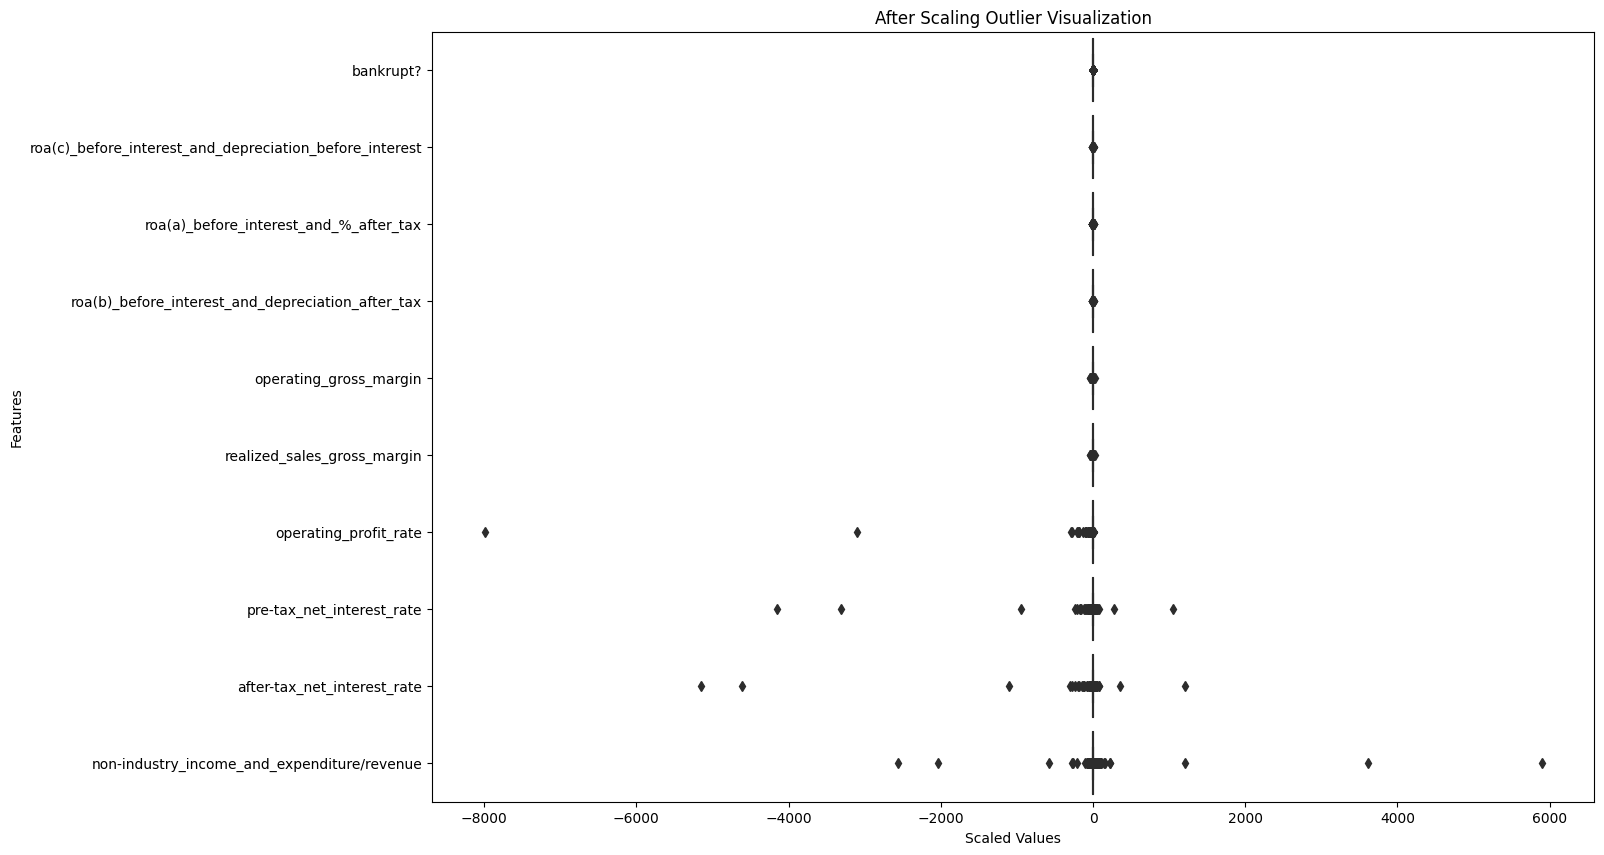

In [11]:
# Applying RobustScaler to numeric columns
scaler = RobustScaler()
data_scaled = data.copy()
data_scaled[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Visualize the effect of scaling using box plots
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_scaled[subset_columns], orient='h', palette='viridis')
plt.title('After Scaling Outlier Visualization')
plt.xlabel('Scaled Values')
plt.ylabel('Features')
plt.show()

## Handling Target Imbalance With SMOTE

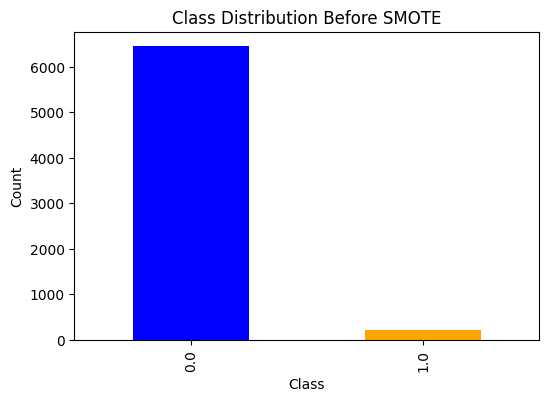

In [12]:
# Check class distribution before SMOTE
class_distribution = data_scaled['bankrupt?'].value_counts()
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
# Separate features and target
X = data_scaled.drop(columns=['bankrupt?'])
y = data_scaled['bankrupt?']

In [14]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

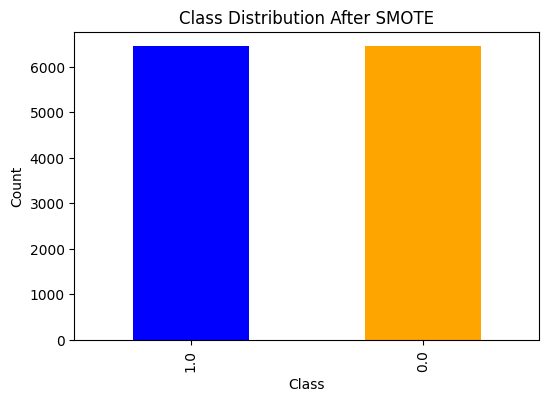

In [15]:
# Check class distribution after SMOTE
resampled_class_distribution = y_resampled.value_counts()
plt.figure(figsize=(6, 4))
resampled_class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [16]:
# Convert resampled arrays back to DataFrame format
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['bankrupt?'])

# Concatenate the features and target variable
resampled_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Exploratory Data Analysis (EDA)
EDA to uncover patterns, trends, and relationships in your data

In [17]:
(resampled_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
roa(c)_before_interest_and_depreciation_before_interest,12892.0,-0.640946,1.290819,-8.533113,-1.207378,-0.530531,0.056291,8.447848
roa(a)_before_interest_and_%_after_tax,12892.0,-0.891396,1.706626,-10.476531,-1.598877,-0.569388,0.055102,8.241837
roa(b)_before_interest_and_depreciation_after_tax,12892.0,-0.723716,1.432756,-9.721018,-1.320773,-0.533493,0.062922,7.884072
operating_gross_margin,12892.0,-0.182107,1.168144,-45.372909,-0.635588,-0.295197,0.249398,29.509984
realized_sales_gross_margin,12892.0,-0.179667,1.168982,-45.494048,-0.630961,-0.294372,0.251623,29.591450
...,...,...,...,...,...,...,...,...
degree_of_financial_leverage_(dfl),12892.0,9.751914,118.078977,-216.153528,-1.244999,-0.137915,0.955530,7846.769364
interest_coverage_ratio_(interest_expense_to_ebit),12892.0,-0.118091,17.569694,-982.217058,-1.204529,-0.149507,1.024838,755.445265
net_income_flag,12892.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
equity_to_liability,12892.0,0.078243,1.541112,-1.188658,-0.531397,-0.342446,0.110412,34.050895


## Correlations With Bankruptcy

In [18]:
# Compute the correlation matrix
correlation_matrix = resampled_data.corr()

In [19]:
# Extract top correlations with the target variable ('Bankrupt?')
target_correlations = correlation_matrix['bankrupt?'].sort_values(ascending=False)

In [20]:
# Visualize the top positive and negative correlations
top_positive_correlations = target_correlations[target_correlations > 0.1].sort_values(ascending=False)
top_negative_correlations = target_correlations[target_correlations < -0.1].sort_values()

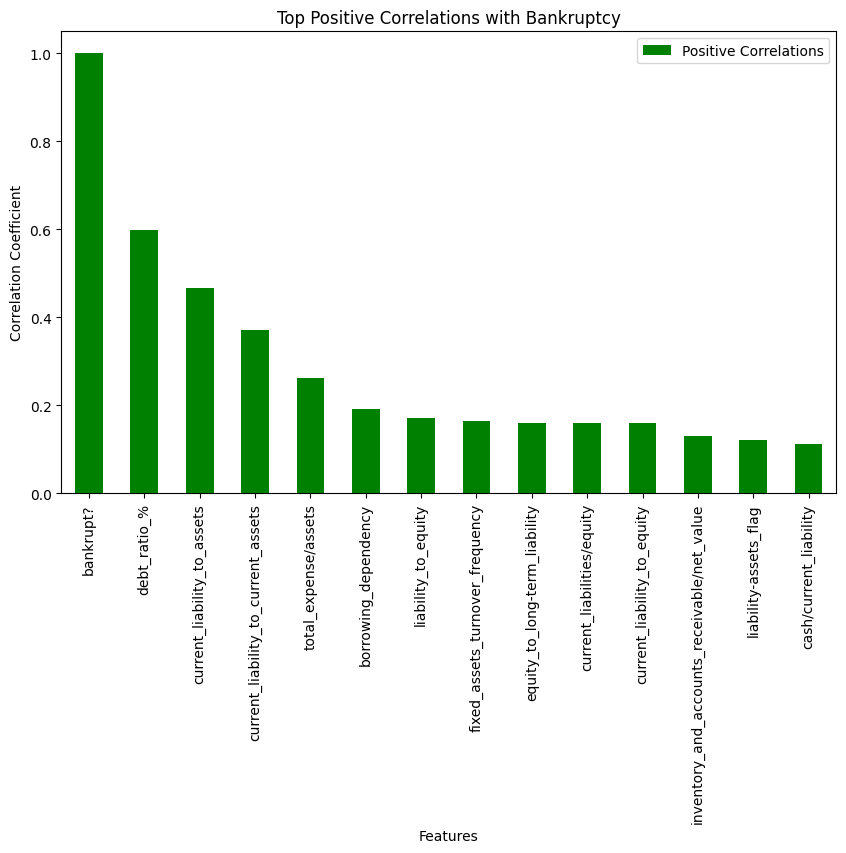

In [21]:
#Top Positive Correlations with Bankruptcy
plt.figure(figsize=(10, 6))
top_positive_correlations.plot(kind='bar', color='green', label='Positive Correlations')
plt.title('Top Positive Correlations with Bankruptcy')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.legend()
plt.show()

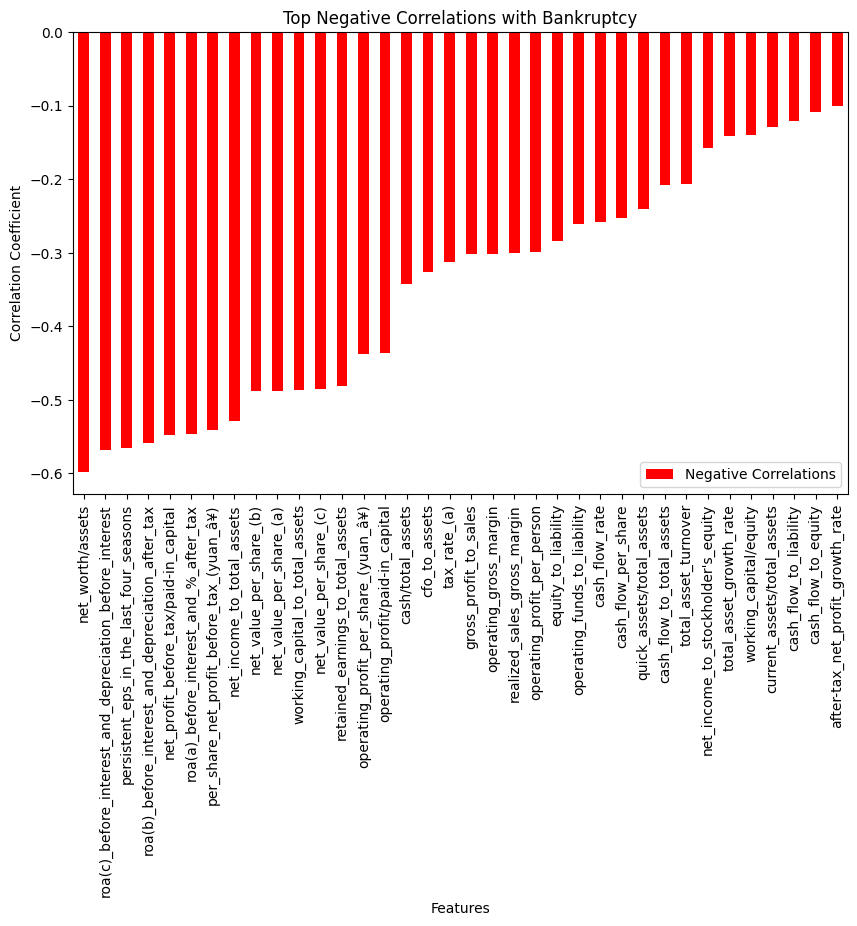

In [22]:
#Top Negative Correlations with Bankruptcy
plt.figure(figsize=(10, 6))
top_negative_correlations.plot(kind='bar', color='red', label='Negative Correlations')
plt.title('Top Negative Correlations with Bankruptcy')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.legend()
plt.show()

# Machine Learning
## Data Preparation

In [23]:
# Assuming the processed data from earlier steps (with SMOTE) is available
X = resampled_data.drop(columns=['bankrupt?'])
y = resampled_data['bankrupt?']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


- resampled_data contains the balanced dataset (after applying SMOTE).
- Features (X) and target (y) are separated.
- The dataset is split into 80% training and 20% testing using train_test_split with stratify to preserve the class balance.

## Feature Selection

In [24]:
# Correlation-based feature selection
correlation_matrix = X.corrwith(y)
top_features = correlation_matrix.abs().sort_values(ascending=False).head(20).index
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


- We calculate the correlation between each feature and the target variable.
- The top 20 features with the highest absolute correlations are selected.
- This step reduces the dimensionality of the dataset and focuses on key predictors.

## Model Training with Hyperparameter Tuning

In [25]:
# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]  # To handle class imbalance
}

# Grid search with cross-validation
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.8}


- Model Definition: XGBClassifier is used for its robust handling of structured data.
Hyperparameter Grid: Various parameters are defined, including:
    - n_estimators: Number of trees.
    - max_depth: Tree depth.
    - learning_rate: Learning step size.
    - scale_pos_weight: Addresses class imbalance.
- Grid Search: Optimizes hyperparameters using 5-fold cross-validation to select the best parameter combination.
- Best Model: The optimal model is stored as best_model.

## Model Evaluation

In [26]:
y_train_pred = best_model.predict(X_train_selected)
y_test_pred = best_model.predict(X_test_selected)

# Training and Testing Performance
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 1.0
Testing Accuracy: 0.9612252811167119
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      1290
         1.0       0.93      0.99      0.96      1289

    accuracy                           0.96      2579
   macro avg       0.96      0.96      0.96      2579
weighted avg       0.96      0.96      0.96      2579



- The model’s predictions are evaluated on training and testing data.
- accuracy_score and classification_report (precision, recall, F1-score) provide insights into model performance on balanced datasets.

# Visualization

## Confusion Matrix

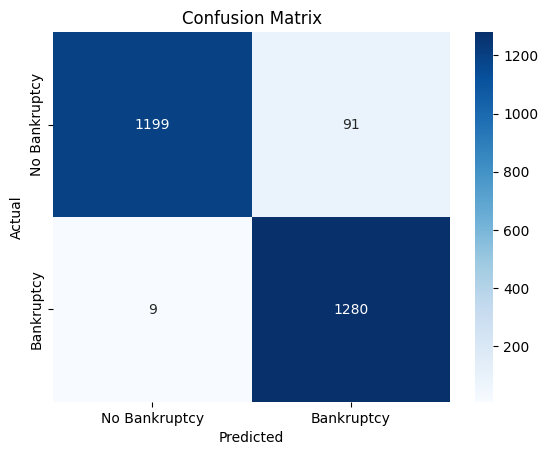

In [27]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Bankruptcy', 'Bankruptcy'], 
            yticklabels=['No Bankruptcy', 'Bankruptcy'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The confusion matrix visualizes true positive, false positive, true negative, and false negative counts to assess prediction accuracy.

## ROC Curve

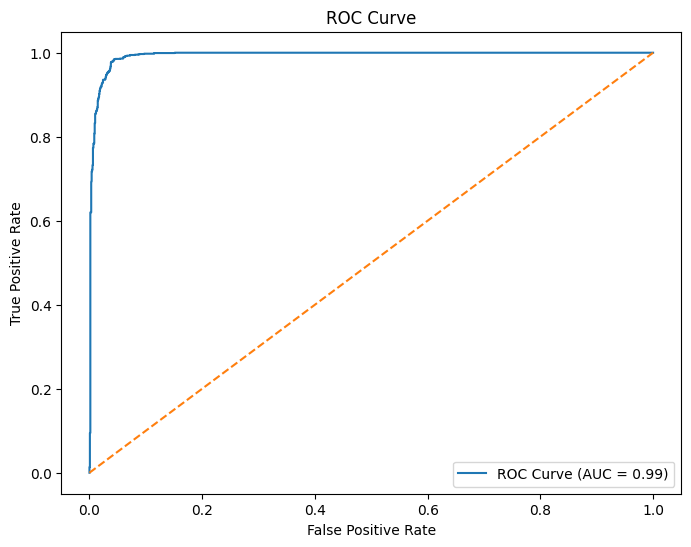

In [28]:
y_test_prob = best_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

- The ROC curve plots the tradeoff between sensitivity and specificity.
- The AUC quantifies the model's discriminative power, where a higher value indicates better performance.

## Precision-Recall Curve

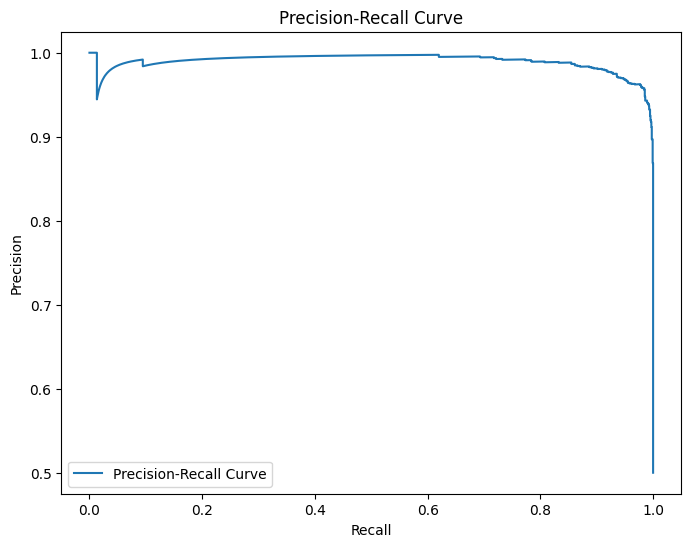

In [29]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

- Precision-Recall curves highlight performance for imbalanced datasets.
- They show the model's ability to predict bankruptcy (minority class).


## Learning Curve

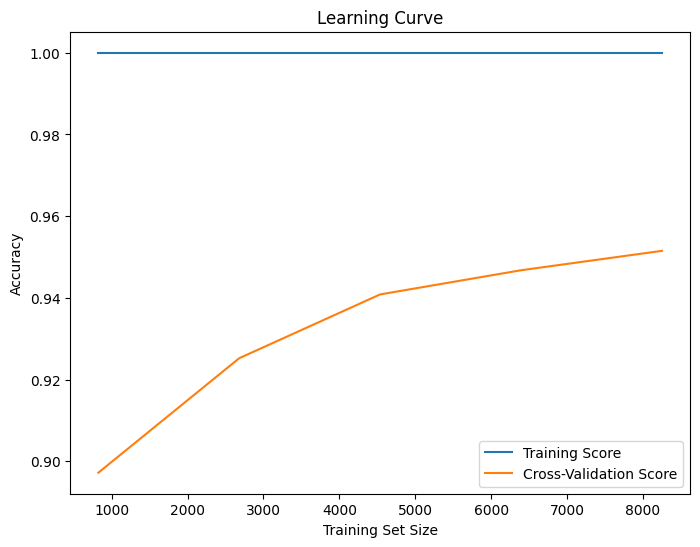

In [30]:
train_sizes, train_scores, test_scores = learning_curve(best_model, 
                                                        X_train_selected, 
                                                        y_train, cv=5, 
                                                        scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()

The learning curve visualizes training and validation accuracy across different dataset sizes.
Gaps between curves may indicate overfitting or underfitting.

## Feature Importance

<Figure size 1000x800 with 0 Axes>

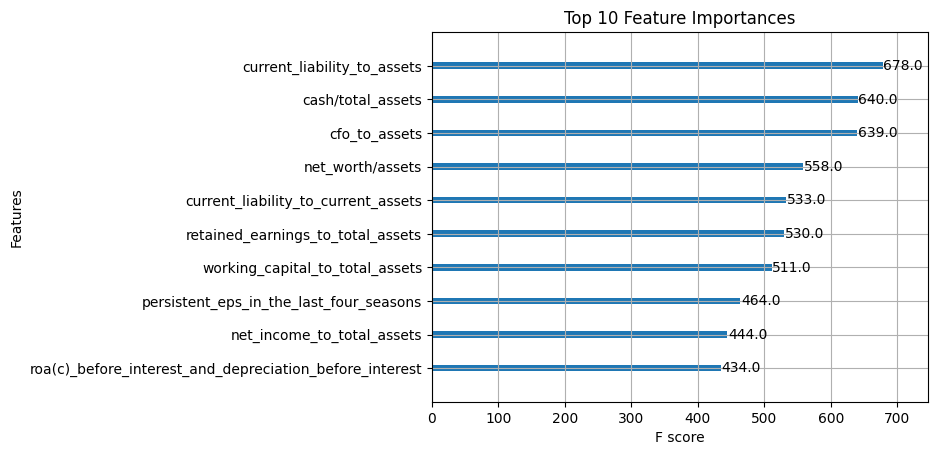

In [31]:
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

- Feature importance ranks predictors based on their contribution to model performance.
The plot highlights the top 10 influential features.